<a href="https://colab.research.google.com/github/hanghae-plus-AI/AI-1-gwkcareer/blob/main/week1/1_3_MNIST(%EC%8B%AC%ED%99%94).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MNIST 예측 모델에 deep learning techniques 적용하기**



# SGD와 Adam 성능 비교

- Dataset을 MNIST에서 [CIFAR10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)으로 변경해줍니다.
- Activation 함수를 `nn.ReLU`에서 `nn.LeakyReLU`로 변경해줍니다.
- 학습 인자는 `n_epochs` = 50, `batch_size` = 256로 설정합니다
- 입력 shape은 model을 선언할 때 중요하기 때문에 MNIST 실습 자료에서 사용한 방식과 똑같이 shape을 확인 후 변경
- 먼저 [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)을 사용하여 학습하는 코드를 구현합니다.
- (Plot 1) SGD와 Adam을 학습시킨 후 각각의 epoch에 대한 train 정확도를 plot합니다.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch import nn
from matplotlib import pyplot as plt
from torch.optim import SGD, Adam

데이터 로드

In [ ]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10( # MNIST에서 CIFAR10으로 변경
    root='./data',
    train=True,
    download=True,
    transform=transform
)
testset = torchvision.datasets.CIFAR10( # MNIST에서 CIFAR10으로 변경
    root='./data',
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 170498071/170498071 [00:04<00:00, 34899701.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


50000
torch.Size([3, 32, 32]) 6


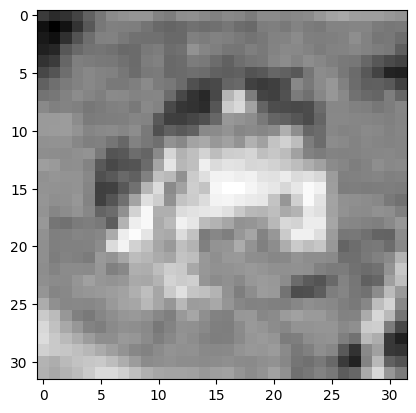

In [ ]:
print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

In [ ]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

데이터 shape 확인

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


In [ ]:
class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU() # nn.ReLU에서 nn.LeakyReLU로 변경

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x

# 모델 초기화
model = Model(3 * 32 * 32, 1024).to('cuda')

In [ ]:
lr = 0.001

# 옵티마이저 설정
sgd_optimizer = SGD(model.parameters(), lr=lr)
adam_optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
# model 정확도 측정 함수
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [ ]:
# model 정확도 시각화
def plot_acc1(train_sgd, test_sgd, train_adam, test_adam):
  x = np.arange(len(train_sgd))

  plt.plot(x, train_sgd, label='SGD train')
  plt.plot(x, test_sgd, label='SGD test')
  plt.plot(x, train_adam, label='Adam train')
  plt.plot(x, test_adam, label='Adam test')

  plt.legend()
  plt.show()

Epoch   0 | Loss(SGD): 450.0973665714264
Epoch   1 | Loss(SGD): 447.98970103263855
Epoch   2 | Loss(SGD): 446.18931889533997
Epoch   3 | Loss(SGD): 444.4172043800354
Epoch   4 | Loss(SGD): 442.5363473892212
Epoch   5 | Loss(SGD): 440.52255845069885
Epoch   6 | Loss(SGD): 438.2845633029938
Epoch   7 | Loss(SGD): 435.89115262031555
Epoch   8 | Loss(SGD): 433.3045587539673
Epoch   9 | Loss(SGD): 430.52102041244507
Epoch  10 | Loss(SGD): 427.6301350593567
Epoch  11 | Loss(SGD): 424.6378130912781
Epoch  12 | Loss(SGD): 421.58375692367554
Epoch  13 | Loss(SGD): 418.5057098865509
Epoch  14 | Loss(SGD): 415.61922955513
Epoch  15 | Loss(SGD): 412.7708203792572
Epoch  16 | Loss(SGD): 410.2086069583893
Epoch  17 | Loss(SGD): 407.77210211753845
Epoch  18 | Loss(SGD): 405.5512557029724
Epoch  19 | Loss(SGD): 403.39711916446686
Epoch  20 | Loss(SGD): 401.43659567832947
Epoch  21 | Loss(SGD): 399.49147856235504
Epoch  22 | Loss(SGD): 397.7667214870453
Epoch  23 | Loss(SGD): 396.2276277542114
Epoch  2

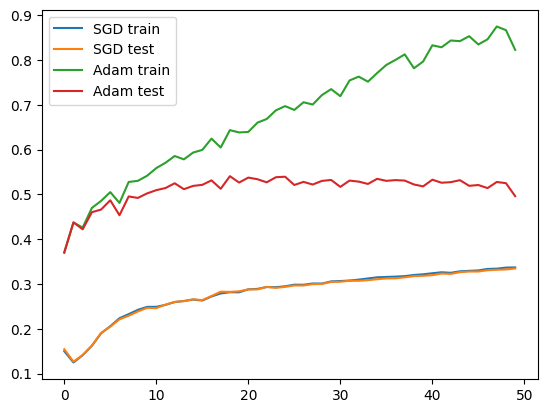

In [ ]:
n_epochs = 50

# 손실 함수 정의 - CrossEntropyLoss
criterion = nn.CrossEntropyLoss()


# 옵티마이저 설정
optimizers = {
    'SGD': sgd_optimizer,
    'Adam': adam_optimizer
}

# 정확도 저장을 위한 리스트
train_accuracies_sgd = []
test_accuracies_sgd = []
train_accuracies_adam = []
test_accuracies_adam = []

for optimizer_name, optimizer in optimizers.items():
  train_accuracies = []
  test_accuracies = []

  for epoch in range(n_epochs):
    model.train()
    total_loss = 0.
    for data in trainloader:
      model.zero_grad()
      inputs, labels = data
      inputs, labels = inputs.to('cuda'), labels.to('cuda')

      # 모델 예측
      preds = model(inputs)

      # 손실함수 계산 - CrossEntropyLoss
      loss = criterion(preds, labels)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    model.eval()
    train_accuracy = accuracy(model, trainloader)
    test_accuracy = accuracy(model, testloader)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch:3d} | Loss({optimizer_name}): {total_loss}")

  # 정확도 저장
  if optimizer_name == 'SGD':
      train_accuracies_sgd = train_accuracies
      test_accuracies_sgd = test_accuracies
  elif optimizer_name == 'Adam':
      train_accuracies_adam = train_accuracies
      test_accuracies_adam = test_accuracies


# 정확도 플로팅
plot_acc1(train_accuracies_sgd, test_accuracies_sgd, train_accuracies_adam, test_accuracies_adam)

# **Leaky ReLU와 Sigmoid 성능 비교**
- Activation 함수가 `nn.Sigmoid`인 class를 새로 정의합니다.
- (Plot 2) Adam optimizer를 가지고 sigmoid와 leaky ReLU 모델들을 학습한 후, epoch에 따른 train 정확도를 비교합니다.


In [ ]:
class SigmoidModel(nn.Module):
    def __init__(self, input_dim, n_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)
        self.sigmoid = nn.Sigmoid()  # Sigmoid 활성화 함수

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.sigmoid(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        x = self.layer3(x)
        return x


class LeakyReLUModel(nn.Module):
    def __init__(self, input_dim, n_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)
        self.leaky_relu = nn.LeakyReLU()  # LeakyReLU 활성화 함수

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.leaky_relu(self.layer1(x))
        x = self.leaky_relu(self.layer2(x))
        x = self.layer3(x)
        return x

# 모델 초기화
model_sigmoid = SigmoidModel(3 * 32 * 32, 1024).to('cuda')
model_leaky_relu = LeakyReLUModel(3 * 32 * 32, 1024).to('cuda')


In [ ]:
lr = 0.001

# 옵티마이저 설정
sigmoid_optimizer = Adam(model_sigmoid.parameters(), lr=lr)
leaky_relu_optimizer = Adam(model_leaky_relu.parameters(), lr=lr)

In [ ]:
# 정확도 시각화 함수
def plot_acc2(train_accs_sigmoid, train_accs_leaky_relu):
    x = np.arange(len(train_accs_sigmoid))
    plt.plot(x, train_accs_sigmoid, label='Sigmoid train')
    plt.plot(x, train_accs_leaky_relu, label='Leaky ReLU train')

    plt.legend()
    plt.show()

Epoch   0 | Loss(sigmoid): 387.94350695610046 | Loss(leaky_relu): 367.35798847675323
Epoch   1 | Loss(sigmoid): 338.9644412994385 | Loss(leaky_relu): 324.41931533813477
Epoch   2 | Loss(sigmoid): 319.1995643377304 | Loss(leaky_relu): 306.0517065525055
Epoch   3 | Loss(sigmoid): 307.50596511363983 | Loss(leaky_relu): 293.72877526283264
Epoch   4 | Loss(sigmoid): 298.5773751735687 | Loss(leaky_relu): 284.37284433841705
Epoch   5 | Loss(sigmoid): 289.4616471529007 | Loss(leaky_relu): 277.3253370523453
Epoch   6 | Loss(sigmoid): 283.118701338768 | Loss(leaky_relu): 270.62159299850464
Epoch   7 | Loss(sigmoid): 278.9578206539154 | Loss(leaky_relu): 263.5419125556946
Epoch   8 | Loss(sigmoid): 272.4322873353958 | Loss(leaky_relu): 256.7349178791046
Epoch   9 | Loss(sigmoid): 266.82926094532013 | Loss(leaky_relu): 251.48702454566956
Epoch  10 | Loss(sigmoid): 261.86686301231384 | Loss(leaky_relu): 244.71192848682404
Epoch  11 | Loss(sigmoid): 258.70863568782806 | Loss(leaky_relu): 239.1570892

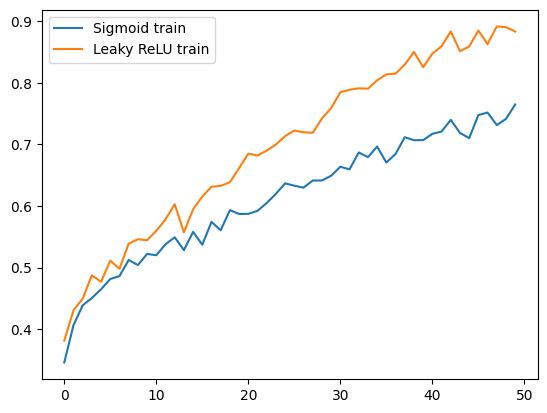

In [ ]:
n_epochs = 50

# 손실 함수 정의 - CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# 정확도 저장을 위한 리스트
train_accuracies_sigmoid = []
train_accuracies_leaky_relu = []


for epoch in range(n_epochs):
  model_sigmoid.train()
  total_loss_sigmoid = 0.
  for data in trainloader:
    model_sigmoid.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    # 모델 예측
    preds = model_sigmoid(inputs)

    # 손실함수 계산 - CrossEntropyLoss
    loss = criterion(preds, labels)
    loss.backward()
    sigmoid_optimizer.step()

    total_loss_sigmoid += loss.item()

  model_sigmoid.eval()
  train_accuracies_sigmoid.append(accuracy(model_sigmoid, trainloader))

  model_leaky_relu.train()
  total_loss_leaky_relu = 0.
  for data in trainloader:
    model_leaky_relu.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    # 모델 예측
    preds = model_leaky_relu(inputs)

    # 손실함수 계산 - CrossEntropyLoss
    loss = criterion(preds, labels)
    loss.backward()
    leaky_relu_optimizer.step()

    total_loss_leaky_relu += loss.item()

  model_leaky_relu.eval()
  train_accuracies_leaky_relu.append(accuracy(model_leaky_relu, trainloader))

  print(f"Epoch {epoch:3d} | Loss(sigmoid): {total_loss_sigmoid} | Loss(leaky_relu): {total_loss_leaky_relu}")

# 정확도 플로팅
plot_acc2(train_accuracies_sigmoid, train_accuracies_leaky_relu)


## Dropout을 적용한 이후의 generalization error 확인
- PyTorch [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)을 leaky ReLU를 사용하는 MLP의 모든 layer에 적용한 class를 새로 정의합니다. Dropout 확률은 0.1로 설정합니다.
- 학습 코드에서 다음 부분들을 추가해줍니다:
    - `model.train()`을 `for data in trainloader:` 이전 줄에 둡니다.
    - `trainloader`와 `testloader`에 대한 정확도를 계산하는 코드를 다음과 같이 변경합니다:
        
        ```python
        with torch.no_grad():
          model.eval()
          <기존 정확도 계산 코드>
        ```
        
- (Plot 3) Adam optimizer를 가지고 dropout을 적용한 모델을 학습한 후, epoch에 따른 train과 test 정확도를 비교합니다.

In [ ]:
class DropoutModel(nn.Module):
    def __init__(self, input_dim, n_dim, dropout_prob=0.1): #0.1 설정
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)

        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout 층
        self.act = nn.LeakyReLU()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(self.act(self.layer1(x)))
        x = self.dropout(self.act(self.layer2(x)))
        x = self.layer3(x)
        return x

# 모델 초기화
model_dropout = DropoutModel(3 * 32 * 32, 1024).to('cuda')

In [ ]:
# model 정확도 시각화
def plot_acc3(train, test):
  x = np.arange(len(train))

  plt.plot(x, train, label='Dropout train')
  plt.plot(x, test, label='Dropout test')

  plt.legend()
  plt.show()

Epoch   0 | Loss: 370.07443726062775
Epoch   1 | Loss: 330.4480048418045
Epoch   2 | Loss: 314.7674003839493
Epoch   3 | Loss: 303.99717462062836
Epoch   4 | Loss: 295.91017162799835
Epoch   5 | Loss: 289.5775099992752
Epoch   6 | Loss: 284.45416021347046
Epoch   7 | Loss: 279.72333538532257
Epoch   8 | Loss: 275.5478525161743
Epoch   9 | Loss: 269.40196418762207
Epoch  10 | Loss: 266.47816014289856
Epoch  11 | Loss: 262.48130691051483
Epoch  12 | Loss: 258.05356550216675
Epoch  13 | Loss: 254.2902992963791
Epoch  14 | Loss: 251.79784178733826
Epoch  15 | Loss: 248.25368130207062
Epoch  16 | Loss: 243.6539489030838
Epoch  17 | Loss: 240.81188595294952
Epoch  18 | Loss: 237.30291783809662
Epoch  19 | Loss: 235.0202407836914
Epoch  20 | Loss: 231.7313482761383
Epoch  21 | Loss: 229.18569445610046
Epoch  22 | Loss: 225.5299723148346
Epoch  23 | Loss: 222.51559138298035
Epoch  24 | Loss: 222.37511867284775
Epoch  25 | Loss: 219.45332717895508
Epoch  26 | Loss: 216.69864457845688
Epoch  27 

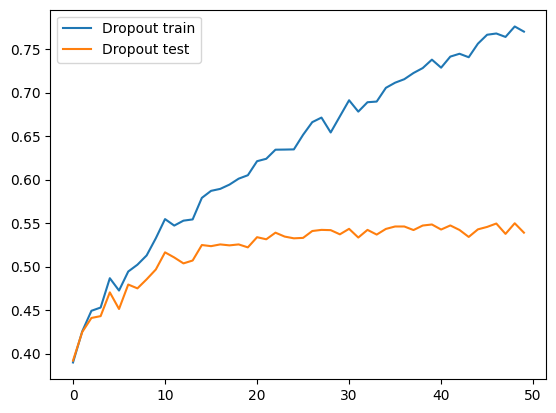

In [ ]:
n_epochs = 50

# 손실 함수 정의 - CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# 옵티마이저 설정
dropout_optimizer = Adam(model_dropout.parameters(), lr=0.001)

dropout_train_accuracies = []
dropout_test_accuracies = []

for epoch in range(n_epochs):
  total_loss = 0.

  model_dropout.train()
  for data in trainloader:
    model_dropout.zero_grad()

    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    # 모델 예측
    preds = model_dropout(inputs)

    # 손실함수 계산 - CrossEntropyLoss
    loss = criterion(preds, labels)
    loss.backward()
    dropout_optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")


  with torch.no_grad():
    model_dropout.eval()
    dropout_train_accuracies.append(accuracy(model_dropout, trainloader))
    dropout_test_accuracies.append(accuracy(model_dropout, testloader))

# 정확도 플로팅
plot_acc3(dropout_train_accuracies, dropout_test_accuracies)